## Predicting Airline Delays Using Supervised Machine Learning Models
### Ian Mathers | Airborne AI | May 25, 2024

### Introduction
The goal of this project is to use supervised machine learning methods and models to predict airline flight delays using basic flight information. Airborne AI is a company that specializes in data science and artificial intelligence solutions for the aviation, finance, and other industries.

Dataset source: https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

In [ ]:
"""
Author: Ian Mathers
Company: Airborne AI
Location: Toronto, ON, Canada
Project: Predicting Airline Delays Using Supervised Machine Learning Models
"""

# Import libraries
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Set max rows and columns viewing options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.3 MB/s eta 0:00:00


### 1 | Exploratory Data Analysis

In [ ]:
# Load CSV dataset
df = pd.read_csv("Airlines.csv")

Show first 5 rows of the DataFrame.

In [ ]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


Provide information such as the types of data in the DataFrame, number of entries, and whether there are any null or missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


The DataFrame contains 539,383 entries. There are 9 columns comprised primarily of integers but also textual data. There are no missing values.

The column names include:
- id: The row ID, this is redundant in our analysis and will be removed.
- Airline: The name of the airline.
- Flight: The flight number.
- AirportFrom: Departure airport.
- AirportTo: Destination airport.
- DayOfWeek: Day of the week in numerical format.
- Time: Time of day in minutes.
- Length: Length of the flight in minutes.
- Delay: The target variable uses binary values. 1 for a delay, 0 for none.

Since the column id is redundant, it will be removed from the DataFrame.

In [ ]:
# Drop column id
df.drop(['id'], axis=1, inplace=True)

Provide summary statistics of the numerical columns in the DataFrame.

In [ ]:
df.describe()

,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,2427.928630,3.929668,802.728963,132.202007,0.445442
std,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,10.000000,0.000000,0.000000
25%,712.000000,2.000000,565.000000,81.000000,0.000000
50%,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,7814.000000,7.000000,1439.000000,655.000000,1.000000


The statistics above reveal that the average flight time was approximately 132 minutes. The shortest was 0 minutes and the longest 655 minutes. The former likely meant a cancellation.

Show histograms of the numerical columns.

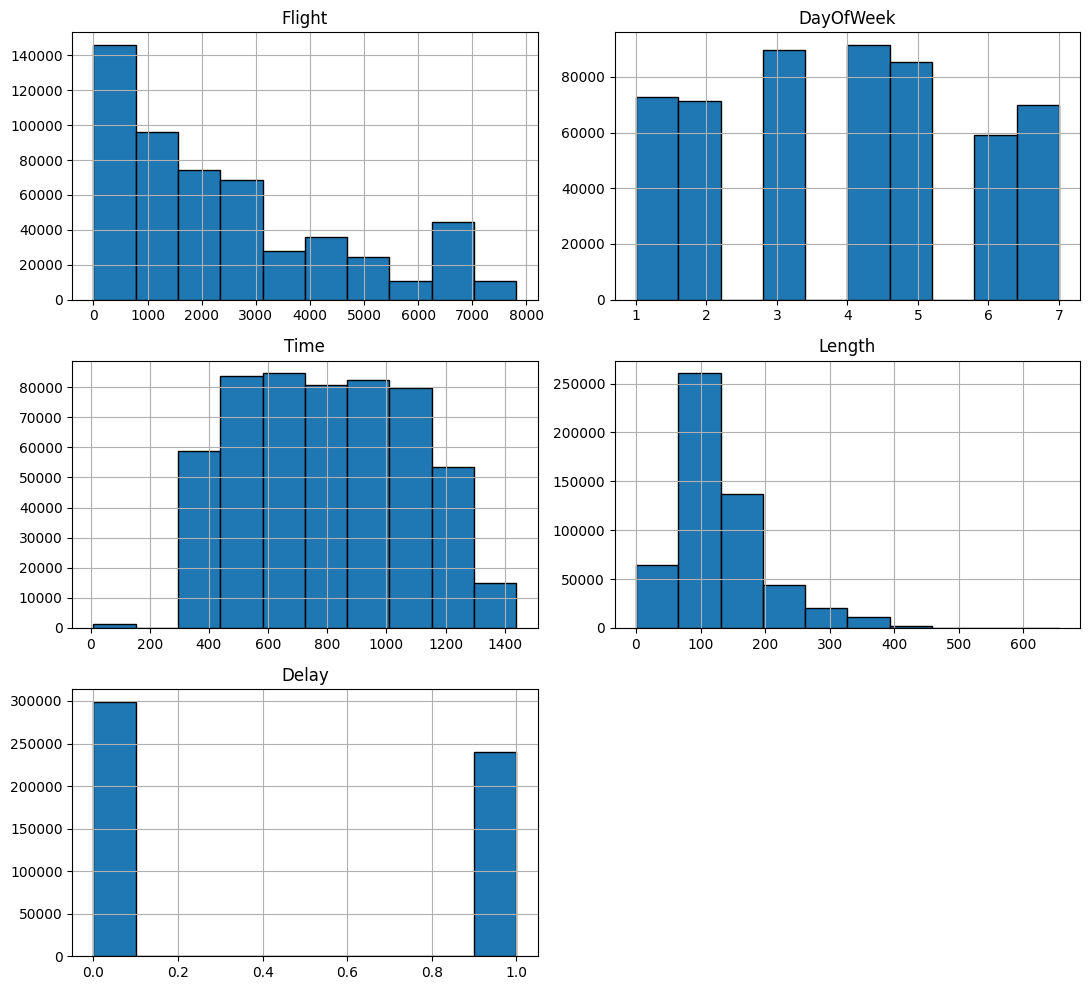

In [ ]:
# Graph histograms
df.hist(figsize=(11,10), ec="k")
plt.tight_layout()

The histograms show that the number of flights were fairly evenly distributed across the different days of the week. Time of day wise, most took place between 400 and 1200 minutes. These equate to approximately 0630 and 2000. As for the length of flights, most were approximately 100-200 minutes. Finally, the target variable, delay, shows balance between the two values. This fact will be important when assessing performance metrics from the different models.

Show the number of delays based on the airline.

<Axes: xlabel='Airline', ylabel='count'>

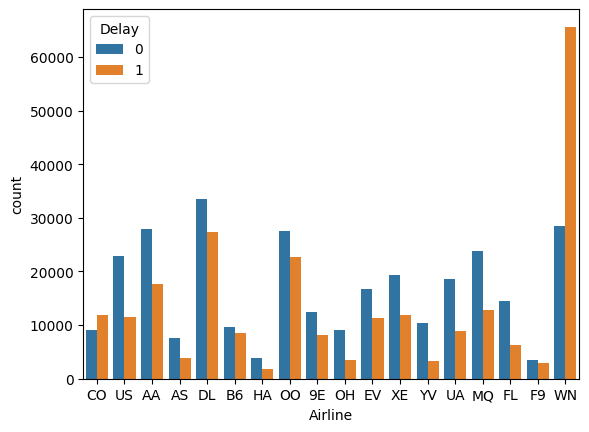

In [ ]:
# Use countplot to show delays for each airline
sns.countplot(data=df, x='Airline', hue='Delay')

### 2 | Data Preprocessing
The data needs to be preprocessed in order for it to work properly with the different models. Categorical features will be transformed using dummy variables, and the numerical features will be scaled using the MinMaxScaler.

In [ ]:
# Assign categorical columns
cat_cols = ["Airline", "AirportFrom", "AirportTo", "DayOfWeek"]

# Transform categorical columns using dummy variables
cat_df = pd.get_dummies(df[cat_cols], drop_first=True)

# Show first 5 rows of the transformed data
cat_df.head()

,DayOfWeek,Airline_AA,Airline_AS,Airline_B6,Airline_CO,Airline_DL,Airline_EV,Airline_F9,Airline_FL,Airline_HA,Airline_MQ,Airline_OH,Airline_OO,Airline_UA,Airline_US,Airline_WN,Airline_XE,Airline_YV,AirportFrom_ABI,AirportFrom_ABQ,AirportFrom_ABR,AirportFrom_ABY,AirportFrom_ACT,AirportFrom_ACV,AirportFrom_ACY,AirportFrom_ADK,AirportFrom_ADQ,AirportFrom_AEX,AirportFrom_AGS,AirportFrom_ALB,AirportFrom_AMA,AirportFrom_ANC,AirportFrom_ASE,AirportFrom_ATL,AirportFrom_ATW,AirportFrom_AUS,AirportFrom_AVL,AirportFrom_AVP,AirportFrom_AZO,AirportFrom_BDL,AirportFrom_BET,AirportFrom_BFL,AirportFrom_BGM,AirportFrom_BGR,AirportFrom_BHM,AirportFrom_BIL,AirportFrom_BIS,AirportFrom_BKG,AirportFrom_BLI,AirportFrom_BMI,AirportFrom_BNA,AirportFrom_BOI,AirportFrom_BOS,AirportFrom_BQK,AirportFrom_BQN,AirportFrom_BRO,AirportFrom_BRW,AirportFrom_BTM,AirportFrom_BTR,AirportFrom_BTV,AirportFrom_BUF,AirportFrom_BUR,AirportFrom_BWI,AirportFrom_BZN,AirportFrom_CAE,AirportFrom_CAK,AirportFrom_CDC,AirportFrom_CDV,AirportFrom_CEC,AirportFrom_CHA,AirportFrom_CHO,AirportFrom_CHS,AirportFrom_CIC,AirportFrom_CID,AirportFrom_CLD,AirportFrom_CLE,AirportFrom_CLL,AirportFrom_CLT,AirportFrom_CMH,AirportFrom_CMI,AirportFrom_CMX,AirportFrom_COD,AirportFrom_COS,AirportFrom_COU,AirportFrom_CPR,AirportFrom_CRP,AirportFrom_CRW,AirportFrom_CSG,AirportFrom_CVG,AirportFrom_CWA,AirportFrom_CYS,AirportFrom_DAB,AirportFrom_DAL,AirportFrom_DAY,AirportFrom_DBQ,AirportFrom_DCA,AirportFrom_DEN,AirportFrom_DFW,AirportFrom_DHN,AirportFrom_DLH,AirportFrom_DRO,AirportFrom_DSM,AirportFrom_DTW,AirportFrom_EAU,AirportFrom_ECP,AirportFrom_EGE,AirportFrom_EKO,AirportFrom_ELM,AirportFrom_ELP,AirportFrom_ERI,AirportFrom_EUG,AirportFrom_EVV,AirportFrom_EWN,AirportFrom_EWR,AirportFrom_EYW,AirportFrom_FAI,AirportFrom_FAR,AirportFrom_FAT,AirportFrom_FAY,AirportFrom_FCA,AirportFrom_FLG,AirportFrom_FLL,AirportFrom_FLO,AirportFrom_FNT,AirportFrom_FSD,AirportFrom_FSM,AirportFrom_FWA,AirportFrom_GCC,AirportFrom_GEG,AirportFrom_GFK,AirportFrom_GGG,AirportFrom_GJT,AirportFrom_GNV,AirportFrom_GPT,AirportFrom_GRB,AirportFrom_GRK,AirportFrom_GRR,AirportFrom_GSO,AirportFrom_GSP,AirportFrom_GTF,AirportFrom_GTR,AirportFrom_GUC,AirportFrom_GUM,AirportFrom_HDN,AirportFrom_HLN,AirportFrom_HNL,AirportFrom_HOU,AirportFrom_HPN,AirportFrom_HRL,AirportFrom_HSV,AirportFrom_HTS,AirportFrom_IAD,AirportFrom_IAH,AirportFrom_ICT,AirportFrom_IDA,AirportFrom_ILM,AirportFrom_IND,AirportFrom_IPL,AirportFrom_ISP,AirportFrom_ITH,AirportFrom_ITO,AirportFrom_IYK,AirportFrom_JAC,AirportFrom_JAN,AirportFrom_JAX,AirportFrom_JFK,AirportFrom_JNU,AirportFrom_KOA,AirportFrom_KTN,AirportFrom_LAN,AirportFrom_LAS,AirportFrom_LAX,AirportFrom_LBB,AirportFrom_LCH,AirportFrom_LEX,AirportFrom_LFT,AirportFrom_LGA,AirportFrom_LGB,AirportFrom_LIH,AirportFrom_LIT,AirportFrom_LMT,AirportFrom_LNK,AirportFrom_LRD,AirportFrom_LSE,AirportFrom_LWB,AirportFrom_LWS,AirportFrom_LYH,AirportFrom_MAF,AirportFrom_MBS,AirportFrom_MCI,AirportFrom_MCO,AirportFrom_MDT,AirportFrom_MDW,AirportFrom_MEI,AirportFrom_MEM,AirportFrom_MFE,AirportFrom_MFR,AirportFrom_MGM,AirportFrom_MHK,AirportFrom_MHT,AirportFrom_MIA,AirportFrom_MKE,AirportFrom_MKG,AirportFrom_MLB,AirportFrom_MLI,AirportFrom_MLU,AirportFrom_MMH,AirportFrom_MOB,AirportFrom_MOD,AirportFrom_MOT,AirportFrom_MQT,AirportFrom_MRY,AirportFrom_MSN,AirportFrom_MSO,AirportFrom_MSP,AirportFrom_MSY,AirportFrom_MTJ,AirportFrom_MYR,AirportFrom_OAJ,AirportFrom_OAK,AirportFrom_OGG,AirportFrom_OKC,AirportFrom_OMA,AirportFrom_OME,AirportFrom_ONT,AirportFrom_ORD,AirportFrom_ORF,AirportFrom_OTH,AirportFrom_OTZ,AirportFrom_PAH,AirportFrom_PBI,AirportFrom_PDX,AirportFrom_PHF,AirportFrom_PHL,AirportFrom_PHX,AirportFrom_PIA,AirportFrom_PIE,AirportFrom_PIH,AirportFrom_PIT,AirportFrom_PLN,AirportFrom_PNS,AirportFrom_PSC,AirportFrom_PSE,AirportFrom_PSG,AirportFrom_PSP,AirportFrom_PVD,AirportFrom_PWM,AirportFrom_RAP,AirportFrom_RDD,AirportFrom_RDM,AirportFrom_RDU,AirportFrom_RIC,AirportFrom_RKS,AirportFrom_RNO,AirportFrom_ROA,AirportFro

The DataFrame above shows the categorical features after being transformed to dummy variables.

In [ ]:
# Assign numerical columns
num_cols = ["Flight", "Time", "Length"]

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Scale numerical data and assign results
num_scaled = scaler.fit_transform(df[num_cols])

# Convert results to a DataFrame
num_df = pd.DataFrame(num_scaled, columns=scaler.get_feature_names_out())

# Show first 5 rows of the scaled data using MinMaxScaler
num_df.head()

,Flight,Time,Length
0,0.034302,0.003499,0.312977
1,0.199283,0.003499,0.338931
2,0.307052,0.006998,0.251908
3,0.315500,0.006998,0.297710
4,0.013695,0.013996,0.308397


The scaled numerical features are shown in the above DataFrame. With both transformations completed, the next step is to combine them into one DataFrame.

In [ ]:
# Combine both transformed categorical and scaled data into a features DataFrame
X = pd.concat([cat_df, num_df], axis=1)

# Assign target variable
y = df["Delay"]

The final step in the preprocessing phase is to split the data into training and testing sets. A 20% test size will be used. Their respective sizes are shown below.

In [ ]:
# Split data into training and test sets using 20% test size
# Random state set to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Show training set size
print('Training set size: ', X_train.shape)
# Show testing set size
print('Test set size: ', X_test.shape)

Training set size:  (431506, 605)
Test set size:  (107877, 605)


### 3 | Supervised Machine Learning Model Generation and Evaluation
Several supervised machine learning models will be used to attempt to predict airline flight delays using basic flight information. As the target variable, Delay, is fairly balanced, accuracy will be used as the performance metric. 3-fold cross validation, accuracy scores for each fold, and an average score will be used to determine the performance of each model.

**Model 1: Logistic Regression**

In [ ]:
# Instantiate Logistic Regression model with a random_state of 42
clf = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation on the training set using the accuracy score
clf_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=3)

# Show scores
print("Accuracy Scores: ", clf_scores)
print()
# Show the average of the scores
print("Average Accuracy Score: ", round(clf_scores.mean(), 2))

Accuracy Scores:  [0.64226619 0.64332742 0.64604582]

Average Accuracy Score:  0.64


**Model 2: Naïve Bayes**

In [ ]:
# Instantiate Naïve Bayes model using GaussianNB
nb = GaussianNB()

# Perform cross-validation on the training set using the accuracy score
nb_scores = cross_val_score(nb, X_train, y_train, scoring="accuracy", cv=3)

# Show scores
print("Accuracy Scores: ", nb_scores)
print()
# Show the average of the scores
print("Average Accuracy Score: ", round(nb_scores.mean(), 2))

F1 Scores:  [0.50904962 0.50808218 0.50524328 0.50258977 0.50649471]

Average F1 Score:  0.51


**Model 3: AdaBoost Classifier**

In [ ]:
# Instantiate AdaBoost Classifier model with a random state of 42
ada = AdaBoostClassifier(random_state=42)

# Perform cross-validation on the training set using the accuracy score
ada_scores = cross_val_score(ada, X_train, y_train, scoring="accuracy", cv=3)

# Show scores
print("Accuracy Scores: ", ada_scores)
print()
# Show the average of the scores
print("Average Accuracy Score: ", round(ada_scores.mean(), 2))

Accuracy Scores:  [0.64177257 0.64471095 0.64552439]

Average Accuracy Score:  0.64


**Model 4: XGBoost Classifier**

In [ ]:
# Instantiate XGBoost Classifier with a random state of 42
xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform cross-validation on the training set using the accuracy score
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, scoring="accuracy", cv=3)

# Show scores
print("Accuracy Scores: ", xgb_scores)
print()
# Show the average of the scores
print("Average Accuracy Score: ", round(xgb_scores.mean(), 2))

Accuracy Scores:  [0.66134347 0.66381618 0.66620086]

Average Accuracy Score:  0.66


Four models were tested, of these the XGBoost Classifier achieved the best result with an accuracy score of 66%. The AdaBoost Classifier and Logistic Regression models provided the next best scores of 64%. In last place was the Naïve Bayes Model with an accuracy of 51%.

### 4 | Final Model and Evaluation
The best performing model, the XGBoost Classifier, was then fitted using the entire training set and used to make delay predictions on the unseen test set. A confusion matrix, classification report, and the final accuracy score of 67% are shown. In addition, the 10 most important features as determined by the algorithm are plotted.

Confusion matrix 
 [[48779 11100]
 [24939 23059]]

              precision    recall  f1-score   support

    No Delay       0.66      0.81      0.73     59879
       Delay       0.68      0.48      0.56     47998

    accuracy                           0.67    107877
   macro avg       0.67      0.65      0.65    107877
weighted avg       0.67      0.67      0.66    107877

Final Model Accuracy Score:  0.67


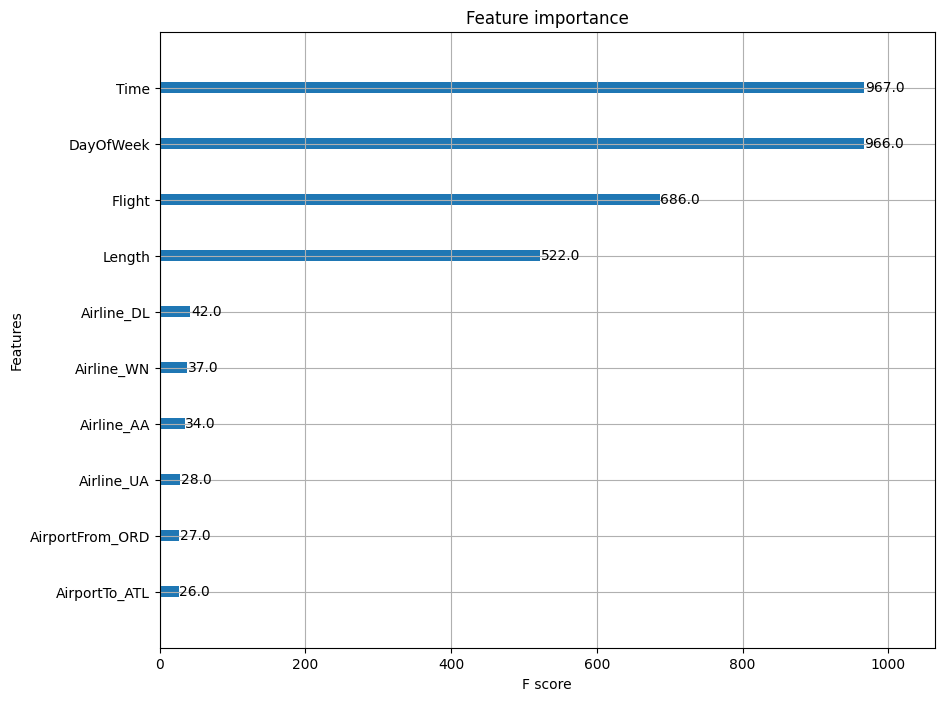

In [ ]:
# Fit final model using the entire training set
xgb_clf.fit(X_train, y_train)

# Assign predictions from final model
preds = xgb_clf.predict(X_test)

# Show confusion matrix
print("Confusion matrix \n", metrics.confusion_matrix(y_test, preds))
print()

# Assign target names
target_names = ["No Delay", "Delay"]

# Show classification report
print(metrics.classification_report(y_test, preds, target_names=target_names))

# Show final model accuracy score
acc_score = metrics.accuracy_score(y_test, preds)
print("Final Model Accuracy Score: ", round(acc_score, 2))

# Plot top 10 feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_clf, max_num_features=10, ax=ax)
plt.show()

### 5 | Conclusion
The final model achieved an accuracy score of 67%. As the feature importance plot shows, it determined that the top 4 features had significantly more influence on the target variable, Delay, than the remaining ones. Time was the most important feature, followed by DayOfWeek, Flight, and Length. The XGBoost Classifier was able to achieve a 67% accuracy score using only limited and basic flight information combined with the baseline algorithm, no hyperparameter tuning was applied. Further accuracy improvements could be achieved through the availability of more data. Much of it would be proprietary for each airline. In addition, further gains could be achieved by optimizing the dataset, using feature engineering, having access to more powerful resources, hyperparameter tuning, and the application of more advance methods. With the right data and tools, production level results could be achieved to help airlines optimize their operations.